This notebook contains visualizations for the types of expenses amongst projects that make low, medium, and high amounts of money.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
%matplotlib inline

In [2]:
df = pd.read_csv('../../data/asking_group_npm_gh.csv')

C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (44,45,46,47,48,49,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
regex = {"Donations": r'(donation|Sponsor|Sponsoship|Sponshorship)', 
         "Engineering" : r'(engineering|development|Code Review|documentation|maintenance|issues|fixes|bug|Maintain|Work|Developing|contribution|Implementation|developement|dev.|Fix|Bounty|\#\d|Support|test|engineer|Frontend|Management|contrib|Webpack|Q\d|Compensation|front end|release|translation|Team communication platform|Typescript typings for Material-UI|2017/08 \+ 2017/09|Updated CLI migration transformations|dynamic imports|Optimize|improvement|enable|JS.?Heroes|convert|packaging|cleanup|Template|issue|Redesign|migration)',
         "Social": r'(Sticker|Hoodie|Twitter ads|hosting|Shirt|Business Cards|Branding|marketing|logo|Advertising|Cards|Nametag|pins|badge|banner|maskot|poster|moderation|art|button|swag|stamps|raffle|Goodies|community|Apparel|July Invoice|Invoice - Apr|Newsletter|Birthday|Brand|Postage|Envelopes|Blog|mascot|prize|pens)',
         "Services": r'(Hardware|Infrastructure|Subscription|Server|Domain|Circle CI|CircleCI|TravisCI|iPhone 5|Verizon|Photoshop|Laptop|Computer|AWS|IntelliJ|Firebase service|book|web service|Supplies|Windows 10|Linode|Raspberry Pi|Host|Github|Google|Open Collective|Paypal|Fees|Mac|office|License|Amazon|renewal|Heroku|Leagal|Accounting|MongoDB|equipment|License|membership|VPN|Copywriting|Phone|subscribe|subscription|Cloud|codefund|codeclub|software|cable|git|Code Fund|service|Appveyor|Annual Plan|GraphQL|Namecheap|Superfeedr|Material|npm org|Wireless|Desk|Keyboard|DNS|projector|yearly|Zapier|Uptime Robot|RAM|monthly|Markdown|Destiny)', 
         "Travel/Food": r'(trip|travel|Food|Meetup|Uber|conference|Lyft|Airbnb|Pizza|Meeting|Event|Flight|Hotel|Ticket|Stay for|Train|Transportation|Underground|Dinner|Summit|Transport|coffee|Hackathon|Amtrak|Florida|Beer|Drinks|Visa|Gas|accommodation|Accomodation|lodging|Conf|London|Toronto|Amsternam|Seattle|Meal|Japan|Airfare|Edinburgh|parking|airport|bart|ride|Almond milk|Cupcake|Taco|Cerveza|Asaba|Adelaide|girls|bagels|meet up|breakfast|Paris|Europe|ClojureX|IN/Clojure|Take out|Attendance|Lunch|Berlin|brazil|colombia|china|IWD2018)'}

In [4]:
def convert_datetime(x):
    if not isinstance(x, str):
        return x
    # Ignore time zone info
    if 'T' in x and 'Z' in x:
        x = x.split('T')[0]
    try:
        temp = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    except:
        try:
            temp = datetime.strptime(x, '%Y-%m-%d')
        except:
            try:
                temp = datetime.strptime(x, '%m/%d/%Y')
            except:
                try:
                    temp = datetime.strptime(x, '%m/%d/%Y %H:%M:%S')
                except:
                    temp = datetime.strptime(x, '%m/%d/%Y %H:%M')
    return temp

In [5]:
def get_expenses(url, regex):
    path = '../data_mining/files/20190719_OpenCollective CSV'
    url_name = url.split('#')[0].rstrip()
    url_name = url_name.split('/')[-1]
    url_name = url_name.split(' ')[0]
    directory = os.fsencode(path)
    expense_dict = {}
    for file in os.listdir(directory):
        # Open csv file
        file = file.decode("utf-8")
        name = file.split('--')[0]
        if name == url_name.lower():
            df_oc = pd.read_csv(path+'/'+file)
            df_oc = df_oc[df_oc["Transaction Amount"] < 0]
            if df_oc.empty:
                return (url_name, 0, None)
            total_expense = -df_oc["Transaction Amount"].sum()
            for reg in regex:
                df_filtered = df_oc[df_oc['Transaction Description'].str.contains(regex[reg], case=False, na=False)]
                df_oc = df_oc[~df_oc['Transaction Description'].str.contains(regex[reg], case=False, na=False)]
                if df_filtered.empty:
                    amount = 0
                else:
                    amount = -df_filtered["Transaction Amount"].sum()
                expense_dict[reg] = amount
            if df_oc.empty:
                expense_dict['Unclassified'] = 0
            else:
                expense_dict['Unclassified'] = -df_oc["Transaction Amount"].sum()
            return (url_name, total_expense, expense_dict)
    return (url_name, 0, None)

Get breakdown of expenses of all projects

In [6]:
dicts = df.to_dict('records')
df_expenses = pd.DataFrame(columns=['slug', 'url', 'earning_last9months', 'total_expense', 'Engineering', 
                            'Services', 'Travel/Food', 'Donations', 'Social', 'Unclassified'])
for row in dicts:
    if not pd.isna(row['opencollective_url']):
        (url_name, total_expense, expense_dict) = get_expenses(row['opencollective_url'], regex)
        if expense_dict is None:
            expense_dict = {'Engineering':0, 
                            'Services':0, 'Travel/Food':0, 'Donations':0, 'Social':0, 'Unclassified':0}
        expense_dict['slug'] = row['slug']
        expense_dict['url'] = url_name
        expense_dict['total_expense'] = total_expense
        expense_dict['earning_last9months'] = row['earning_last9months']
        df_expenses = df_expenses.append(expense_dict, ignore_index=True)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
C:\ProgramData\Miniconda3\lib\site-packages\ip

Find fractions

In [7]:
types = ['Engineering', 'Services', 'Travel/Food', 'Donations', 'Social', 'Unclassified']
for typ in types:
    df_expenses[typ+'_frac'] = 0

In [8]:
for index, row in df_expenses.iterrows():
    if row['total_expense'] == 0:
        continue
    for typ in types:
        df_expenses.loc[index, typ+'_frac'] = (row[typ]/row['total_expense'])*100

In [9]:
df_expenses.head()

,slug,url,earning_last9months,total_expense,Engineering,Services,Travel/Food,Donations,Social,Unclassified,Engineering_frac,Services_frac,Travel/Food_frac,Donations_frac,Social_frac,Unclassified_frac
0,checkstyle/checkstyle,checkstyle,20.00,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
1,clojure-emacs/cider,cider,9283.00,5063.64,4950,113.64,0,0,0,0,97.755765,2.244235,0.0,0.000000,0.00000,0.000000
2,uraimo/awesome-software-patreons,duplicati,2563.00,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
3,NaturalIntelligence/imglab,imglab,0.00,0,0,0,0,0,0,0,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
4,joshtronic/donate,mochajs,18062.49,3576.9,2563.94,93.96,0,502,67,350,71.680505,2.626856,0.0,14.034499,1.87313,9.785009


Drop duplicates

In [10]:
df_expenses2 = df_expenses.drop_duplicates(subset='url')
df_expenses2.shape

(862, 16)

Make boxplots for projects that don't make much money

In [11]:
def percents(x, pos):
    return '%i%%' % x

In [12]:
df_no_money = df_expenses2[df_expenses2.earning_last9months < 1000]
df_no_money_dummy = pd.DataFrame(columns=['type', 'frac'])
for index, row in df_no_money.iterrows():
    if row['total_expense'] == 0:
        continue
    for typ in types:
        df_no_money_dummy = df_no_money_dummy.append({'type':typ, 'frac':row[typ+'_frac']}, ignore_index=True)

In [13]:
df_no_money_dummy.head()

,type,frac
0,Engineering,0.0
1,Services,0.0
2,Travel/Food,0.0
3,Donations,0.0
4,Social,0.0


In [14]:
def plot_boxplot(df):
    figsize = (6, 5)
    euro_colors = ['#9FCDCD', '#C58293', '#5D7EA7', '#EFC6D1', '#E7E4D3', '#85BB65']
    sns.set(style="white", rc={'figure.figsize':figsize, 'xtick.labelsize':37, 'ytick.labelsize':37})
    ax = sns.boxplot(x='frac', y='type', data=df, showfliers=False, palette=euro_colors, orient="h")
    ax.set(xlabel='', ylabel='')
    formatter = FuncFormatter(percents)
    plt.gca().xaxis.set_major_formatter(formatter)
    sns.despine()
    fig = ax.get_figure()
    return fig

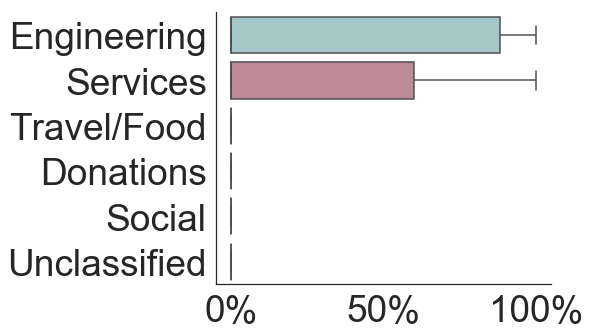

In [15]:
fig = plot_boxplot(df_no_money_dummy)

Repeat for projects that make a lot of money

In [16]:
df_money = df_expenses2[df_expenses2.earning_last9months >= 9000]
df_money_dummy = pd.DataFrame(columns=['type', 'frac'])
for index, row in df_money.iterrows():
    if row['total_expense'] == 0:
        continue
    for typ in types:
        df_money_dummy = df_money_dummy.append({'type':typ, 'frac':row[typ+'_frac']}, ignore_index=True)

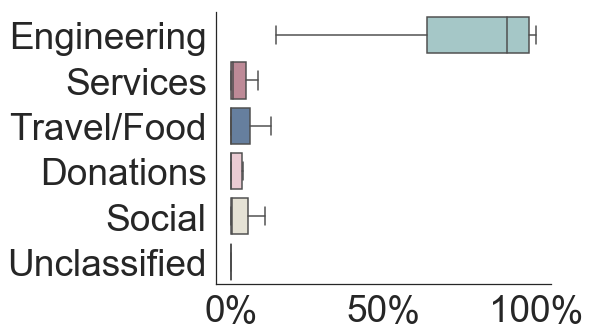

In [17]:
fig = plot_boxplot(df_money_dummy)

Repeat for projects that make some money

In [18]:
df_some_money = df_expenses2[(df_expenses2.earning_last9months < 9000)&(df_expenses2.earning_last9months >= 1000)]
df_some_money_dummy = pd.DataFrame(columns=['type', 'frac'])
for index, row in df_some_money.iterrows():
    if row['total_expense'] == 0:
        continue
    for typ in types:
        df_some_money_dummy = df_some_money_dummy.append({'type':typ, 'frac':row[typ+'_frac']}, ignore_index=True)

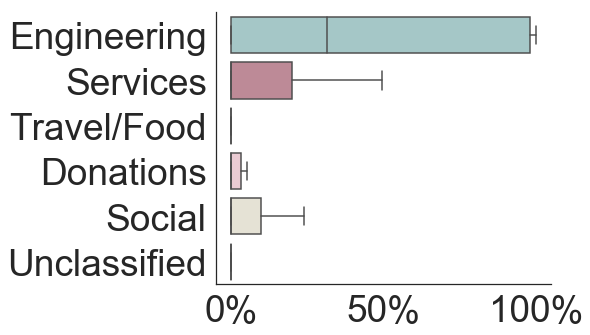

In [19]:
fig = plot_boxplot(df_some_money_dummy)